In [1]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving semeval2016-task6-trainingdata.txt to semeval2016-task6-trainingdata (2).txt
Saving SemEval2016-Task6-subtaskA-testdata.txt to SemEval2016-Task6-subtaskA-testdata (2).txt
Saving vocab.pkl to vocab (1).pkl
User uploaded file "semeval2016-task6-trainingdata.txt" with length 397092 bytes
User uploaded file "SemEval2016-Task6-subtaskA-testdata.txt" with length 180744 bytes
User uploaded file "vocab.pkl" with length 940008 bytes


In [2]:
!ls

 sample_data
'SemEval2016-Task6-subtaskA-testdata (1).txt'
'SemEval2016-Task6-subtaskA-testdata (2).txt'
 SemEval2016-Task6-subtaskA-testdata.txt
'semeval2016-task6-trainingdata (1).txt'
'semeval2016-task6-trainingdata (2).txt'
 semeval2016-task6-trainingdata.txt
'vocab (1).pkl'
 vocab.pkl


In [3]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html


In [4]:
!pip install fastai

In [0]:
from fastai import *
from fastai.text import *
from pathlib import Path
import pandas as pd
import numpy as np
import re

In [0]:
path = Path('./')
trainfile = 'semeval2016-task6-trainingdata.txt'
testfile = 'SemEval2016-Task6-subtaskA-testdata.txt'

In [0]:
def clean_ascii(text):
    return ''.join(i for i in text if ord(i) < 128)

In [8]:
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

Cuda available
PyTorch version:  1.0.0.dev20181206


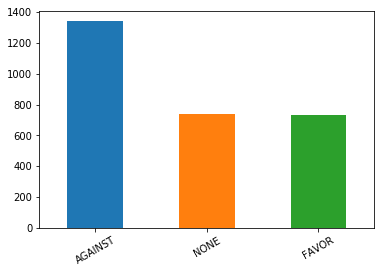

In [10]:
train_orig = pd.read_csv(path/trainfile, delimiter='\t', header=0, encoding = "latin-1")
train_orig['Stance'].value_counts().plot.bar(rot=30);

In [11]:
for item in train_orig['Target'].unique():
    print(item)    

Atheism
Climate Change is a Real Concern
Feminist Movement
Hillary Clinton
Legalization of Abortion


In [12]:
train_orig['Tweet'] = train_orig['Tweet'].apply(clean_ascii)
train_orig.head()

,ID,Target,Tweet,Stance
0,101,Atheism,dear lord thank u for all of ur blessings forg...,AGAINST
1,102,Atheism,"Blessed are the peacemakers, for they shall be...",AGAINST
2,103,Atheism,I am not conformed to this world. I am transfo...,AGAINST
3,104,Atheism,Salah should be prayed with #focus and #unders...,AGAINST
4,105,Atheism,And stay in your houses and do not display you...,AGAINST


In [13]:
train = pd.concat([train_orig['Stance'], train_orig['Tweet']], axis=1)
train.tail()

,Stance,Tweet
2809,AGAINST,"There's a law protecting unborn eagles, but no..."
2810,AGAINST,I am 1 in 3... I have had an abortion #Abortio...
2811,AGAINST,How dare you say my sexual preference is a cho...
2812,AGAINST,"Equal rights for those 'born that way', no rig..."
2813,AGAINST,#POTUS seals his legacy w/ 1/2 doz wins. The #...


In [0]:
train.to_csv(path/'train.csv', index=False, header=False)

In [0]:
data_lm = TextLMDataBunch.from_csv(path, 'train.csv', min_freq=1)

In [0]:
data_lm.save()

In [17]:
data_lm.show_batch()

idx,text
0,& 7 billion comforts . # xxmaj bankrupt # semst xxbos xxup @powsimian does a vegan diet make you immortal ? either way we 're all gon na die # semst xxbos xxmaj you know what 's best xxmaj you know what 's best for your well being xxmaj you know what 's best for your life ... # # semst xxbos @hillaryclinton xxmaj especially the paid union lackies who
1,xxmaj two muslim bodyguards . xxmaj stop glorifying him as anti muslim u idiot xxmaj bhakts ! ! # semst xxbos xxmaj if i ever meet xxmaj hillary xxmaj clinton i will have died and then come back to life b / c i will be so happy # idol # semst xxbos xxmaj the # right to # life should be the # first among # humanrights -pope xxmaj
2,so ur not broke # semst xxbos i need feminism because broken idealogies need defending just as much as functioning ones . # cryingalready # deathnote # semst xxbos xxmaj feminism is not just about women ; it 's about letting all people lead fuller lives ~ @janefonda # life # semst xxbos xxmaj reason 847 i do n't believe in xxmaj god : attacked by a waterbug.*shudders * #
3,"3 / 4 way out of the womb , stick a knife in its head 2 kill the child & xxup @scotus says its xxup ok # semst xxbos @probirdrights : i do a stump speech . xxmaj it on the stump in the park . attendance mandatory . # semst xxbos .@mexonu : # greenclimatefund projects must be long - lasting & lay the groundwork for low - carbon"
4,calling and more cats ! # ndsufeminist # xxmaj feminist # cats # dogscancometoo # semst xxbos ( it 's just a night watcheasy to set up . staggered pickets ( google it ) work best ) # whoisburningblackchurches # semst xxbos ( 1 / 2 ) xxmaj poisoning of the # xxmaj biosphere can not be dealt with by free market economics ; # taxwallstreet # xxmaj environment #


In [0]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.1)

In [20]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(8051, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(8051, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1150, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1150, 1150, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1150, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=8051, bias=True)
   (output_dp): RNNDropout()
 )]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


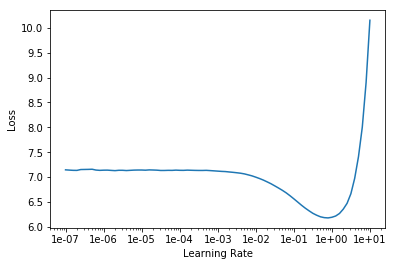

In [21]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [23]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, 
                               drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,7.174391,6.109115,0.148158,00:02


In [24]:
learn.unfreeze()
learn.fit_one_cycle(cyc_len=20, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.753554,5.423313,0.186830,00:03
1,6.364263,4.844238,0.229353,00:03
2,6.048973,4.679100,0.247154,00:03
3,5.807055,4.632821,0.236775,00:03
4,5.589117,4.493597,0.252958,00:03
5,5.358113,4.305147,0.269531,00:03
6,5.095287,4.123811,0.303516,00:03
7,4.849957,4.108587,0.308817,00:03
8,4.632141,4.078046,0.308203,00:03
9,4.459174,4.076385,0.310770,00:03


In [0]:
learn.save_encoder('ft_enc')

In [0]:
topic = "Feminist Movement"
train_topic = train.loc[train_orig['Target'] == topic]

In [0]:
train_topic.to_csv(path/'train_topic.csv', index=False, header=False)

In [0]:
data_clas = TextClasDataBunch.from_csv(path, 'train_topic.csv', vocab=data_lm.train_ds.vocab,min_freq=1, bs=32)
data_clas.save()

In [0]:
learn = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM)
learn.load_encoder('ft_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


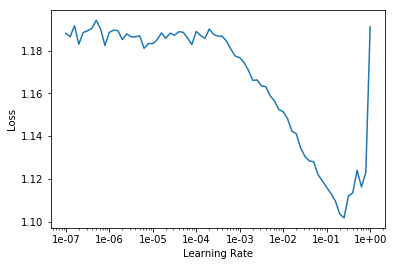

In [31]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.129328,1.085185,0.436090,00:00


In [33]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.062575,0.977356,0.473684,00:00


In [34]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.940906,0.959692,0.466165,00:01


In [35]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.859611,0.957151,0.458647,00:01
1,0.869063,0.945187,0.496241,00:01
2,0.830215,0.935902,0.496241,00:01
3,0.812635,0.941083,0.488722,00:01


In [36]:
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,48,26,15
1,8,12,3
2,8,8,5


In [37]:
test = pd.read_csv(path/testfile, delimiter='\t', header=0, encoding = "latin-1")
test = test.drop(['ID'], axis=1)
test.head()

,Target,Tweet,Stance
0,Atheism,He who exalts himself shall be humbled; a...,UNKNOWN
1,Atheism,RT @prayerbullets: I remove Nehushtan -previou...,UNKNOWN
2,Atheism,@Brainman365 @heidtjj @BenjaminLives I have so...,UNKNOWN
3,Atheism,#God is utterly powerless without Human interv...,UNKNOWN
4,Atheism,@David_Cameron Miracles of #Multiculturalism...,UNKNOWN


In [38]:
test_pred = test[['Target', 'Tweet']]
test_pred = test_pred.loc[test_pred['Target'] == topic]
test_pred.tail()

,Target,Tweet
669,Feminist Movement,@Maisie_Williams is our hero with her #LikeAGi...
670,Feminist Movement,"Rather be an ""ugly"" feminist then be these sad..."
671,Feminist Movement,iamNovaah: RT ChrzOC: Bitches be running wild....
672,Feminist Movement,@angerelle you disagree that people should str...
673,Feminist Movement,#Rapeculture is basically a FABLE. It has almo...


In [0]:
test_pred['Stance'] = test_pred['Tweet'].apply(lambda row: str(learn.predict(row)[0]))

In [40]:
test_pred.tail()

,Target,Tweet,Stance
669,Feminist Movement,@Maisie_Williams is our hero with her #LikeAGi...,FAVOR
670,Feminist Movement,"Rather be an ""ugly"" feminist then be these sad...",AGAINST
671,Feminist Movement,iamNovaah: RT ChrzOC: Bitches be running wild....,AGAINST
672,Feminist Movement,@angerelle you disagree that people should str...,FAVOR
673,Feminist Movement,#Rapeculture is basically a FABLE. It has almo...,AGAINST


In [0]:
test_pred.to_csv(path/'predicted.txt', sep='\t', index=True, header=['Target', 'Tweet', 'Stance'], index_label='ID')

In [43]:
!ls

 data_save.pkl
 models
 predicted.txt
 sample_data
'SemEval2016-Task6-subtaskA-testdata (1).txt'
'SemEval2016-Task6-subtaskA-testdata (2).txt'
 SemEval2016-Task6-subtaskA-testdata.txt
'semeval2016-task6-trainingdata (1).txt'
'semeval2016-task6-trainingdata (2).txt'
 semeval2016-task6-trainingdata.txt
 train.csv
 train_topic.csv
'vocab (1).pkl'
 vocab.pkl


In [0]:
files.download('predicted.txt')